In [271]:
# Importing Modules 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [272]:
# Function for plotting grids with matplotlib
def plot_grid(df, nrows, ncols):
    
    fix, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, linewidth=1)
        
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
        
    plt.tight_layout();

In [273]:
# Read CSVs
df_DJI = pd.read_csv('./DATA/INDICES/DJI_OHLCV.csv', parse_dates=['Date'], infer_datetime_format=True, index_col="Date" )

# Compute stdev
stdev_window = 25
df_DJI['stdev'] = df_DJI['Close'].pct_change().rolling(window=stdev_window).std()

df_DJI.dropna(inplace=True)
print(df_DJI.shape)
df_DJI.head()

(2986, 6)


,Open,High,Low,Close,Volume,stdev
Date,,,,,,
2010-11-05,11435.22,11451.53,11393.52,11444.08,211673104,0.007120
2010-11-08,11439.54,11439.61,11362.53,11406.84,143993472,0.006941
2010-11-09,11403.59,11421.14,11303.19,11346.75,161909792,0.006292
2010-11-10,11342.81,11366.16,11255.02,11357.04,164169600,0.006291
2010-11-11,11326.69,11326.77,11231.22,11283.10,296662720,0.006461


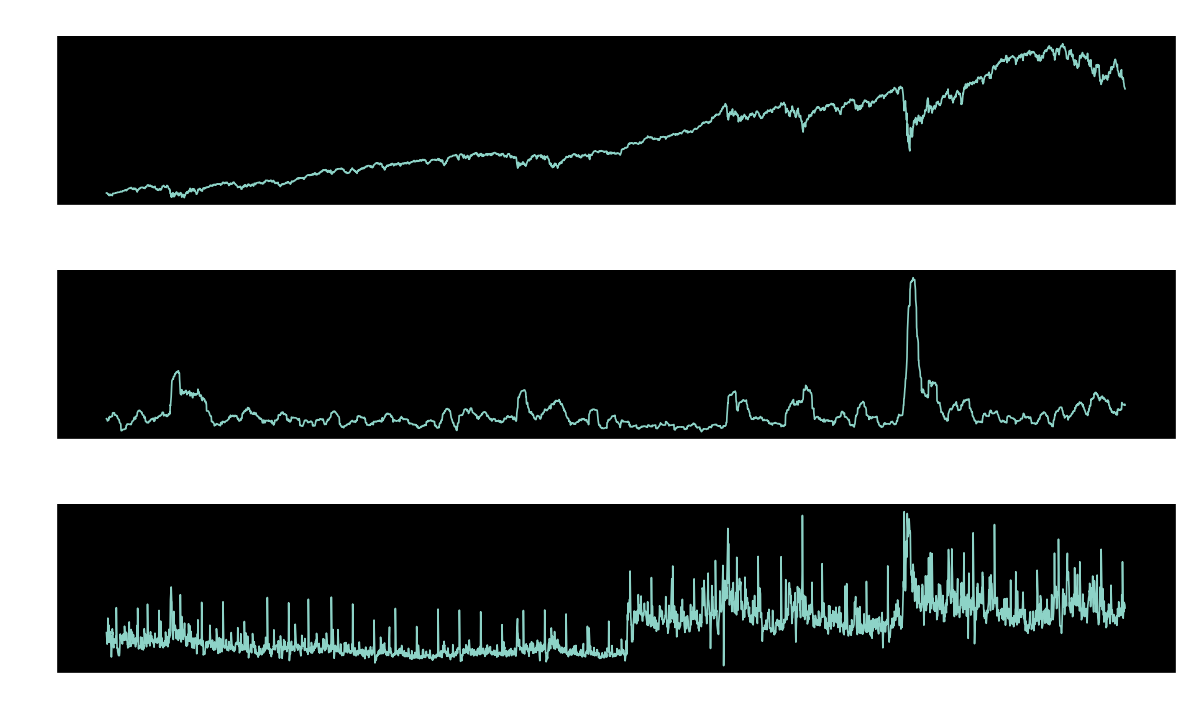

In [274]:
# Plot dataset
plot_grid(df_DJI[['Close', 'stdev', 'Volume']], 3, 1)

In [275]:
# Check stationarity
def check_stationarity(df):
    non_stationary = []
    for column in df:
        adfuller_res = adfuller(df[column][1:])
        adf_stat = adfuller_res[0]
        p_value = adfuller_res[1]
        ci_1 = adfuller_res[-2]['1%']
        ci_5 = adfuller_res[-2]['5%']
        print(f'ADF Statistic ({column}): {adf_stat}')
        print(f'p-value: {p_value}')
        if adf_stat > ci_1 or adf_stat > ci_5:
            non_stationary.append(column)
            print(f'{column} is non stationary.')
        else:
            print(f'{column} is stationary!')
    
    if len(non_stationary) > 0:
        print(f'Non-stationary columns are: {non_stationary}. Try .diff()')
        return non_stationary
    else:
        print(f'All columns are stationary!')
    
non_stationary = check_stationarity(df_DJI)

ADF Statistic (Open): -1.0773492073138669
p-value: 0.7240197453253195
Open is non stationary.
ADF Statistic (High): -0.9619785824815072
p-value: 0.7668780076831763
High is non stationary.
ADF Statistic (Low): -1.1530334244802167
p-value: 0.6934664811956485
Low is non stationary.
ADF Statistic (Close): -0.9443822493817233
p-value: 0.7730057164182889
Close is non stationary.
ADF Statistic (Volume): -2.4404600229814366
p-value: 0.13064088303191929
Volume is non stationary.
ADF Statistic (stdev): -4.817917586530115
p-value: 5.025235839477243e-05
stdev is stationary!
Non-stationary columns are: ['Open', 'High', 'Low', 'Close', 'Volume']. Try .diff()


In [276]:
# Apply one .diff() on non stationary columns
df_DJI_stationary = pd.concat([df_DJI[non_stationary].diff(), df_DJI.drop(columns=non_stationary)], axis=1).dropna()

In [277]:
# Check stationarity again
check_stationarity(df_DJI_stationary)

ADF Statistic (Open): -35.85249601186087
p-value: 0.0
Open is stationary!
ADF Statistic (High): -12.116164813540856
p-value: 1.8703098419156123e-22
High is stationary!
ADF Statistic (Low): -17.19574683127314
p-value: 6.508232562291882e-30
Low is stationary!
ADF Statistic (Close): -11.027409416871848
p-value: 5.781341899201302e-20
Close is stationary!
ADF Statistic (Volume): -17.046056525648407
p-value: 8.132326028012015e-30
Volume is stationary!
ADF Statistic (stdev): -4.815456159621749
p-value: 5.0801787798770924e-05
stdev is stationary!
All columns are stationary!


In [278]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df_DJI_stationary)
df_DJI_scaled = scaler.transform(df_DJI_stationary)
df_DJI_scaled = pd.DataFrame(df_DJI_scaled, columns=df_DJI.columns).dropna()

# Number of .diff() methods performed for stationary conversion
n_diffs = 1

# Number of days in test & train set
n_train = 2500
n_test = len(df_DJI) - n_train - n_diffs - stdev_window

# Split data
df_train = df_DJI_scaled.iloc[:n_train]
df_test = df_DJI_scaled.iloc[n_train:n_test+n_train]

# Create separate test set to preserve index for plotting predictions later
df_DJI_test = df_DJI.iloc[n_train:n_test+n_train]

print(f'Number of training days: {n_train}')
print(f'Number of testing days: {n_test}')

display(df_train.head(3))
display(df_test.head(3))

Number of training days: 2500
Number of testing days: 460


,Open,High,Low,Close,Volume,stdev
0,0.001785,-0.006747,-0.014256,-0.012425,-0.114305,0.113270
1,-0.014856,-0.010455,-0.027297,-0.020049,0.030259,0.102670
2,-0.025117,-0.031121,-0.022159,0.003433,0.003817,0.102662


,Open,High,Low,Close,Volume,stdev
2500,0.087701,0.008609,0.050436,-0.009372,0.026529,0.170192
2501,-0.092495,-0.141905,-0.358652,-0.216940,0.096182,0.176443
2502,-0.220933,-0.270638,0.040389,-0.074135,-0.058377,0.178097


In [279]:
# Split exogenous and endogenous variables
# endog = df_train.drop(columns=['Volume'])
# exog = df_train['Volume']

# Create VARMAX Model
model = VARMAX(
    df_train,
    order=(1,1),
    # error_cov_type='diagonal',
    filter_concentrated=True
)

# Fit model
model_fit = model.fit(disp=True)
# model_fit.summary()

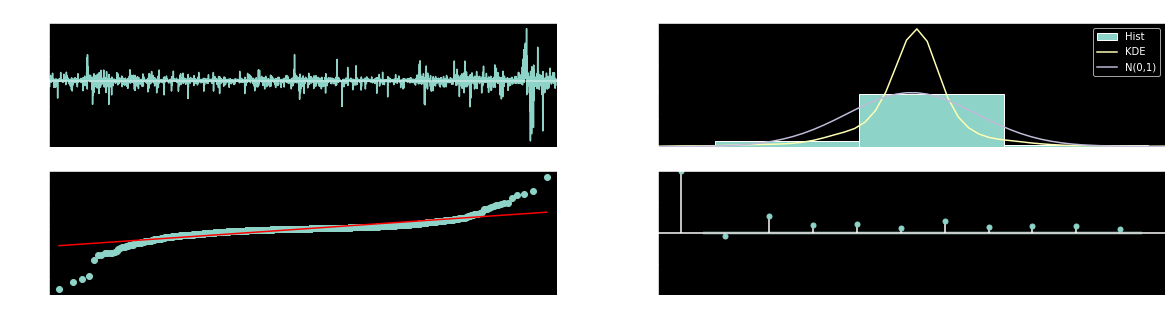

In [280]:
# Plot stdev diagnostics
model_fit.plot_diagnostics(5,figsize=(20,5));

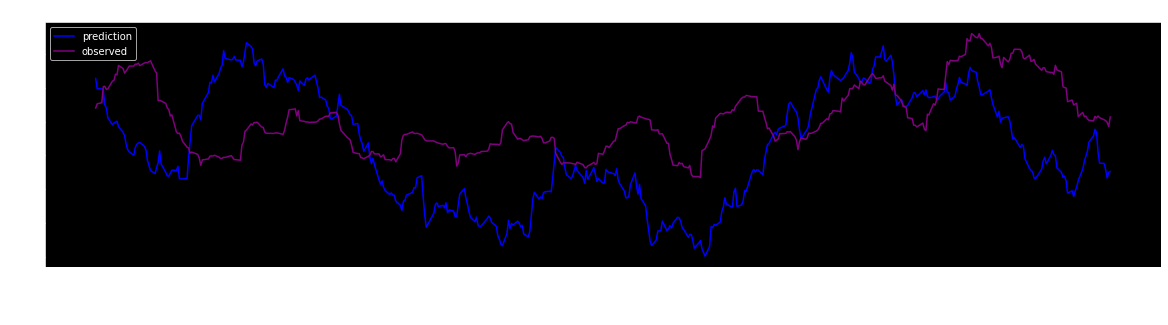

In [281]:
# Set random seed
np.random.seed(1)

# Plot predicted vs observed volatility
pred = pd.DataFrame(index=df_DJI_test.index)
pred['prediction'] = model_fit.simulate(n_test).set_index(pred.index, drop=True).stdev
pred['observed'] = df_test.set_index(pred.index, drop=True).stdev
pred.plot(figsize=(20,5),title='predicted vs observed volatility',color=['blue','purple'])
plt.legend(loc=('upper left'));

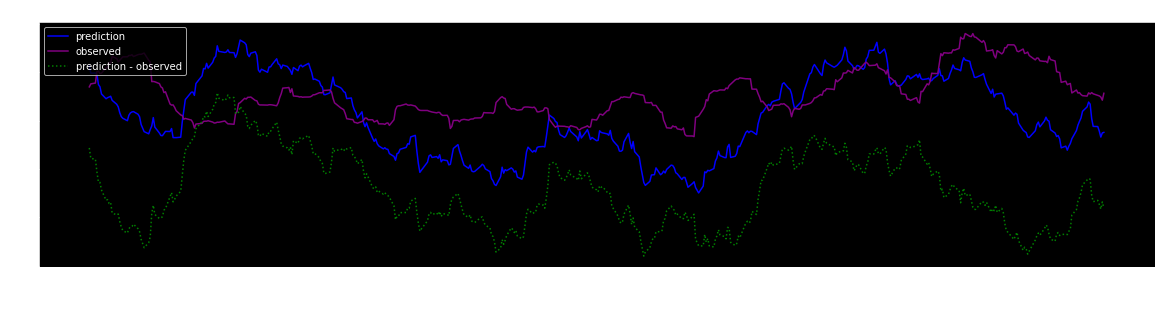

In [282]:
# Plot error
pred['prediction - observed'] = pred['prediction'] - pred['observed']
pred.plot(figsize=(20,5),title='volatility forecast error',color=['blue','purple','green'],style=['-','-',':'])
plt.legend(loc=('upper left'));

In [283]:
# Total Error
error_total = np.round(np.sum(np.abs(pred['prediction - observed'])), 2)
print(f'Total Error: {error_total}')

Total Error: 35.07


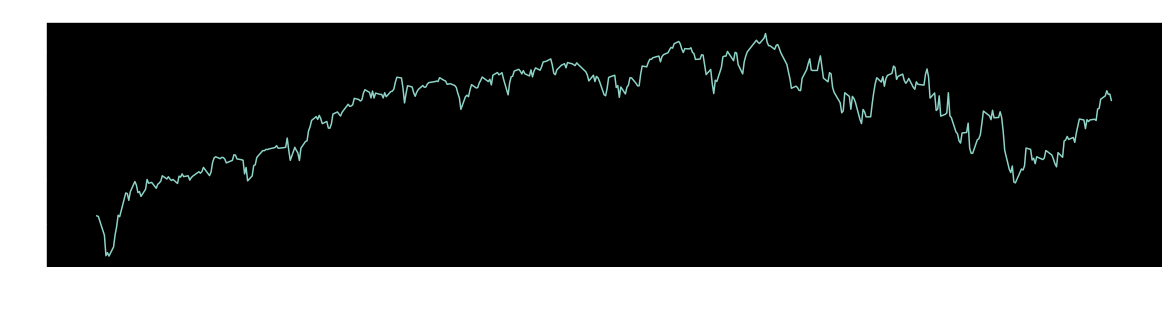

In [284]:
# Compare with Close data
df_DJI_test['Close'].plot(figsize=(20,5), title=('DJI Close'));